In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
import pickle
from os import listdir
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.image import imread
from random import choice

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras import Model

import cv2

In [54]:
!nvidia-smi

Thu Sep 14 12:06:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |   8997MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [55]:
base_path = '/content/gdrive/MyDrive/Colab Notebooks/Mask_Data'


label = choice(['without_mask', 'with_mask'])
class_path = os.path.join(base_path, label)

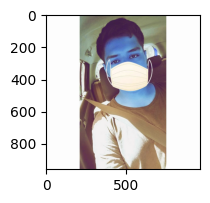

In [56]:
image_name = choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Read and Display the random image
image = cv2.imread(image_path)
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

In [57]:
# biblioteque d'aplicatif pour les données  d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# biblioteque d'aplicatif pour les données de validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# générateurs de données d'entraînement et de validation
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_mask', 'with_mask'])

val_generator = val_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_mask', 'with_mask'],
    shuffle=False)

Found 1508 images belonging to 2 classes.
Found 1508 images belonging to 2 classes.


In [58]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [59]:
for layer in base_model.layers:
    layer.trainable = False

In [60]:
compilation = Flatten()(base_model.output)
compilation = Dense(256, activation='relu')(compilation)
compilation = Dense(128, activation='relu')(compilation)
compilation = Dense(1, activation='sigmoid')(compilation) #1 seul neurone car binary

In [61]:
model = Model(inputs=base_model.input, outputs=compilation)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [62]:
mycallback = ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/best_model', monitor='val_accuracy', save_best_only = True)

# Train the model
history = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=6, callbacks = mycallback )

Epoch 1/6
47/47 [==============================] - 88s 2s/step - loss: 0.3045 - accuracy: 0.9140 - val_loss: 0.0224 - val_accuracy: 0.9934
Epoch 2/6
47/47 [==============================] - 34s 716ms/step - loss: 0.0437 - accuracy: 0.9864 - val_loss: 0.0111 - val_accuracy: 0.9960
Epoch 3/6
47/47 [==============================] - 33s 698ms/step - loss: 0.0185 - accuracy: 0.9946 - val_loss: 0.1001 - val_accuracy: 0.9648
Epoch 4/6
47/47 [==============================] - 36s 765ms/step - loss: 0.0450 - accuracy: 0.9844 - val_loss: 0.0054 - val_accuracy: 0.9980
Epoch 5/6
47/47 [==============================] - 33s 698ms/step - loss: 0.0260 - accuracy: 0.9905 - val_loss: 0.0070 - val_accuracy: 0.9973
Epoch 6/6
47/47 [==============================] - 35s 758ms/step - loss: 0.0772 - accuracy: 0.9783 - val_loss: 0.0074 - val_accuracy: 0.9980


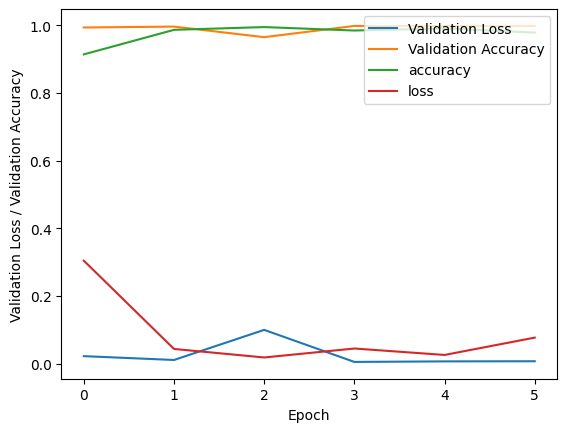

In [64]:
# Tracer la courbe de la val_loss et de la val_accuracy
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss / Validation Accuracy')
plt.legend(loc='upper right')
plt.show()

48/48 [==============================] - 18s 376ms/step


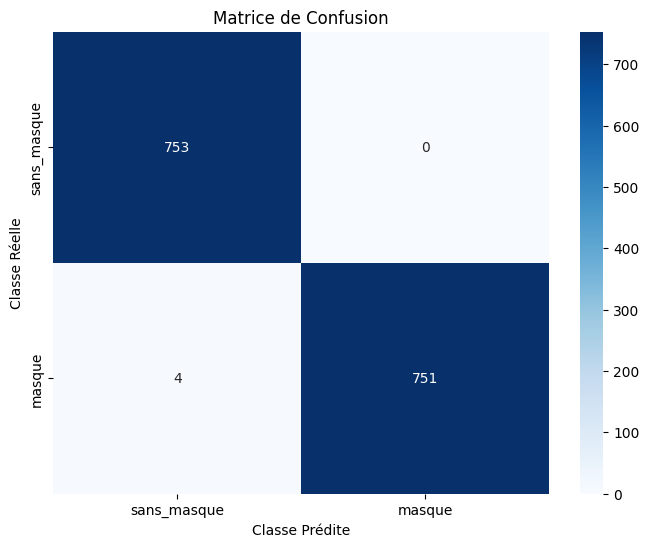

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtenir les prédictions du modèle sur les données de validation
predictions = model.predict(val_generator)

# Convertir les valeurs de probabilité en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int)

# Obtenir les vraies classes des données de validation
true_classes = val_generator.classes

# Calculer la matrice de confusion
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Définir les noms de classe (dans l'ordre des classes)
class_names = ['sans_masque', 'masque']

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Prédite')
plt.ylabel('Classe Réelle')
plt.title('Matrice de Confusion')
plt.show()

Test sur 4 images

In [102]:
def preprocess(image_path):
    image = cv2.imread(image_path)
    resized_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)

    image = np.expand_dims(resized_img, axis=0)
    image = image / 255.0


    return image

In [103]:

test1 = preprocess('/content/gdrive/MyDrive/Colab Notebooks/masque.jpg')
test2 = preprocess('/content/gdrive/MyDrive/Colab Notebooks/sans_masque.jpg')
test3 = preprocess('/content/gdrive/MyDrive/Colab Notebooks/avec_masque2.jpg')
test4 = preprocess('/content/gdrive/MyDrive/Colab Notebooks/sans_masque2.jpg')

In [104]:
test1.shape

(1, 224, 224, 3)

In [105]:
predictions = [model.predict(test1), model.predict(test2), model.predict(test3), model.predict(test4)]


1/1 [==============================] - 0s 22ms/step


In [106]:
for i in predictions :
  if i < 0.5:
    print("pas de masque")
  else:
    print("avec masque")

pas de masque
pas de masque
avec masque
pas de masque


Le modèle a juste pour les 3 derniers et faux pour le dernier.